In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('./../')  # Needed for importing from simulation_utils.py
from simulation_utils import *


### NumPy Sim


In [2]:
def run_numpy_simulation(gate_fidelity, epr_channel_fidelity):
    # Define target state as the Bell state |phi_{00}>
    TARGET_STATE = bell_state()

    # Define BBPSSW circuit (Alice and Bob each apply CNOT: control=first qubit, target=second qubit)
    # NOTE: we apply depolarizing channels only to gates that appear in the original BBPSSW protocol,
    # and not to additional SWAP gates

    bbpssw_circuit = QuantumCircuit([
        Gate(kron([I(), SWAP(), I()])),     # Swap to get 1A, 2A, 1B, 2B

        Gate(kron([CNOT(), I(), I()])),        # Apply CNOT(1A, 2A)
        DepolarizingChannel(gate_fidelity, 4, [0, 1]),

        Gate(kron([I(), I(), CNOT()])),        # Apply  CNOT(1B, 2B)
        DepolarizingChannel(gate_fidelity, 4, [2, 3]),

        Gate(kron([I(), SWAP(), I()])),     # Swap back to get 1A, 1B, 2A, 2B

        # Measure 2A and 2B
        POVM(num_qubits=4, meas_qubits=[2, 3], partial_trace=True),
    ])

    # Create two Werner states
    epr_1 = epr_2 = werner_state(epr_channel_fidelity)

    # Combined system: |1A, 1B, 2A, 2B⟩
    rho = kron([epr_1, epr_2])

    # Apply BBPSSW circuit
    probs, rho_outs = bbpssw_circuit(rho)

    # Compute fidelity wrt. the Bell state phi_00
    fidels = np.array([fidelity(dm, TARGET_STATE) for dm in rho_outs])

    # Compute probability of success and average fidelity **given** success
    prob_succ = np.sum(probs[[0, 3]])
    fidel_succ = np.dot(fidels[[0, 3]], probs[[0, 3]]) / prob_succ

    return prob_succ, fidel_succ

In [3]:
GRID_SIZE = 11
numpy_sim_results = []

for gate_fidelity in np.linspace(0, 1, GRID_SIZE):
    for epr_channel_fidelity in np.linspace(0, 1, GRID_SIZE):
        prob_succ, fidel_succ = run_numpy_simulation(gate_fidelity, epr_channel_fidelity)
        numpy_sim_results.append([gate_fidelity, epr_channel_fidelity, prob_succ, fidel_succ])

numpy_sim_results = np.array(numpy_sim_results)

cols = ['Gate fidelity', 'EPR channel fidelity', 'P_Succ', 'F_succ']
numpy_sim_results = pd.DataFrame(numpy_sim_results, columns=cols)

numpy_sim_results

,Gate fidelity,EPR channel fidelity,P_Succ,F_succ
0,0.0,0.0,0.500,0.250000
1,0.0,0.1,0.500,0.250000
2,0.0,0.2,0.500,0.250000
3,0.0,0.3,0.500,0.250000
4,0.0,0.4,0.500,0.250000
...,...,...,...,...
116,1.0,0.6,0.680,0.735294
117,1.0,0.7,0.745,0.813758
118,1.0,0.8,0.820,0.884146
119,1.0,0.9,0.905,0.946133


### Extracting results from NetQASM

In [4]:
def _get_p_succ_and_f_succ(df: pd.DataFrame):
    """Computes the probability of success and fidelity given success."""
    return [
        1 - (df['M_Alice'] ^ df['M_Bob']).mean(),
        df.query('M_Alice == M_Bob')['Fidelity'].mean(),
    ]


def _series_to_numpy(s: pd.Series):
    """Converts a `pandas.Series` containing lists to a numpy array by depth-1 list flattening."""
    # NOTE: this function can only be applied to the specific series used here
    return np.array([np.concatenate(row) for row in s.items()])


def get_p_succ_and_f_succ(data: pd.DataFrame):
    """
    Computes the probability of success and fidelity given success,
    grouped by gate and EPR channel fidelities, in the given `DataFrame`.
    """
    # Group data by gate and channel fidelity
    result = data.groupby(['Gate fidelity', 'EPR channel fidelity'])

    result = result.apply(_get_p_succ_and_f_succ, include_groups=False)
    result = _series_to_numpy(result)

    cols = ['Gate fidelity', 'EPR channel fidelity', 'P_succ', 'F_succ']
    result = pd.DataFrame(result, columns=cols)

    return result

# Read simulation results
netqasm_sim_results = pd.read_csv('./out_bbpssw.csv')
netqasm_sim_results = get_p_succ_and_f_succ(netqasm_sim_results)

netqasm_sim_results

,Gate fidelity,EPR channel fidelity,P_succ,F_succ
0,0.0,0.0,0.52,0.278846
1,0.0,0.2,0.44,0.261364
2,0.0,0.4,0.46,0.339234
3,0.0,0.6,0.47,0.255319
4,0.0,0.8,0.57,0.263158
5,0.0,1.0,0.55,0.290909
6,0.2,0.0,0.47,0.202128
7,0.2,0.2,0.41,0.231707
8,0.2,0.4,0.50,0.267759
9,0.2,0.6,0.52,0.230843


### Plotting

In [6]:
# Theoretical functions for BBPSSW
def prob_succ_theory(F: float):
    """Theoretical success probability for BBPSSW protocol"""
    return F**2 + (1-F)**2/9 + 2*F*(1-F)/3

def fidelity_succ_theory(F: float):
    """Theoretical fidelity after successful BBPSSW iteration"""
    numerator = F**2 + (1-F)**2/9
    denominator = F**2 + 2*F*(1-F)/3 + 5*(1-F)**2/9
    return numerator / denominator

# def prob_succ_theory(F: float, gate_fidelity: float = 1.0):
#     """Theoretical success probability for BBPSSW protocol with gate noise."""
#     p = gate_fidelity
#     term1 = F**2
#     term2 = 2 * F * (1 - F) / 3
#     term3 = 5 * ((1 - F)**2) / 9
#     return (term1 + term2 + term3) * (p**2)
#
# def fidelity_succ_theory(F: float, gate_fidelity: float = 1.0):
#     """Theoretical fidelity after successful BBPSSW iteration with gate noise."""
#     p = gate_fidelity
#     numerator = (F**2 + ((1 - F)**2)/9) * (p**2)
#     denominator = prob_succ_theory(F, gate_fidelity)
#     return numerator / denominator if denominator != 0 else 0
#
# def f_threshold(gate_fidelity: float):
#     """Compute F_min and F_max where F_succ > F for a given gate fidelity."""
#     p = gate_fidelity
#     sqrt_term = np.sqrt(4 + 6/p - 9/(p**2))
#     F_max = 0.75 + 0.25 * sqrt_term
#     F_min = 0.75 - 0.25 * sqrt_term
#     return F_min, F_max


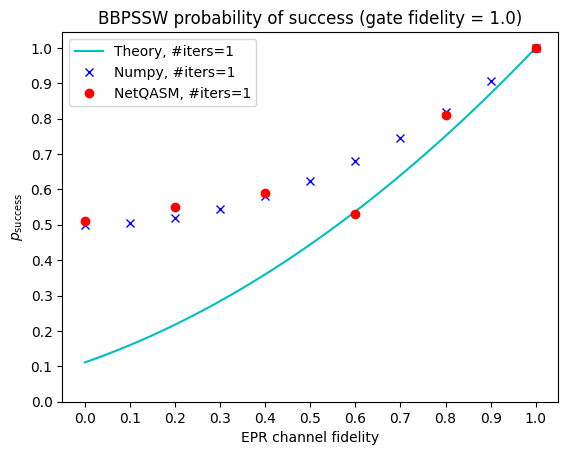

In [7]:
ps = np.linspace(0, 1, 101)
plt.plot(
    ps, prob_succ_theory(ps),
    'c-', label='Theory, #iters=1',
)
plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['P_Succ'],
    'xb', label='Numpy, #iters=1',
)
plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM, #iters=1'
)
plt.title('BBPSSW probability of success (gate fidelity = 1.0)')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

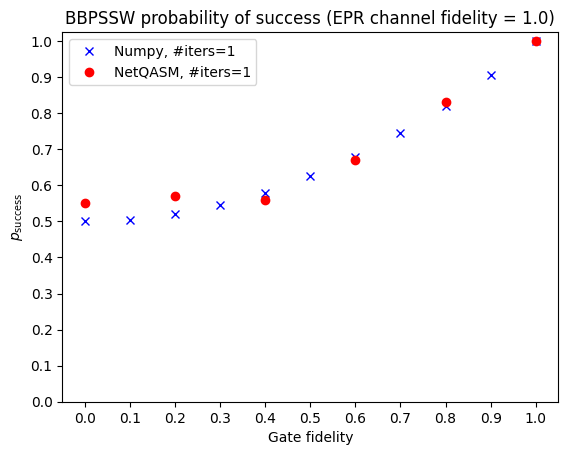

In [8]:
ps = np.linspace(0, 1, 101)
plt.plot(
    numpy_sim_results.query('`EPR channel fidelity` == 1.0')['Gate fidelity'],
    numpy_sim_results.query('`EPR channel fidelity` == 1.0')['P_Succ'],
    'xb', label='Numpy, #iters=1',
)
plt.plot(
    netqasm_sim_results.query('`EPR channel fidelity` == 1.0')['Gate fidelity'],
    netqasm_sim_results.query('`EPR channel fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM, #iters=1'
)
plt.title('BBPSSW probability of success (EPR channel fidelity = 1.0)')
plt.xlabel('Gate fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

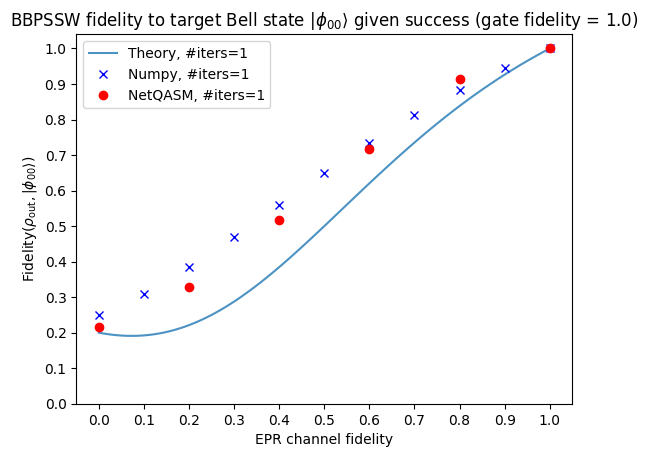

In [10]:
ps = np.linspace(0, 1, 101)


foo = np.vectorize(lambda p: fidelity_succ_theory(p))
plt.plot(
    ps, foo(ps),
    alpha=0.8,
    label=f'Theory, #iters={1}',
)

plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'xb', label='Numpy, #iters=1',
)

plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM, #iters=1'
)

plt.title(r'BBPSSW fidelity to target Bell state $\vert\phi_{00}\rangle$ given success (gate fidelity = 1.0)')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

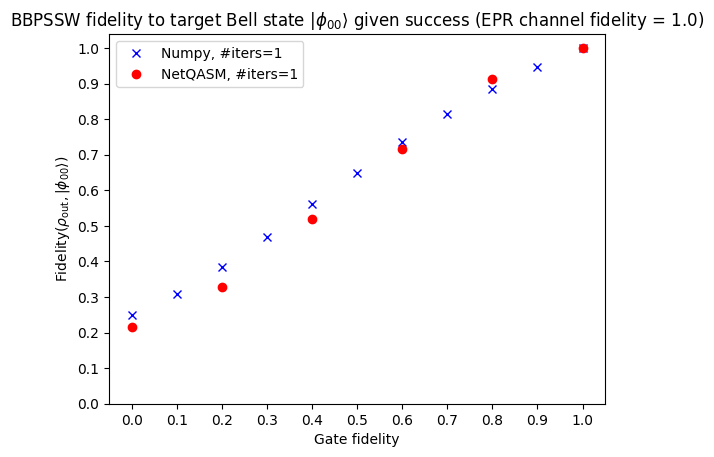

In [11]:
ps = np.linspace(0, 1, 101)

plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'xb', label='Numpy, #iters=1',
)

plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM, #iters=1'
)

plt.title(r'BBPSSW fidelity to target Bell state $\vert\phi_{00}\rangle$ given success (EPR channel fidelity = 1.0)')
plt.xlabel('Gate fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

In [5]:
def prob_succ_theory(F: float, gate_fidelity: float = 1.0):
    """Theoretical success probability for BBPSSW protocol with gate noise."""
    p = gate_fidelity
    term1 = F**2
    term2 = 2 * F * (1 - F) / 3
    term3 = 5 * ((1 - F)**2) / 9
    return (term1 + term2 + term3) * (p**2)

def fidelity_succ_theory(F: float, gate_fidelity: float = 1.0):
    """Theoretical fidelity after successful BBPSSW iteration with gate noise."""
    p = gate_fidelity
    numerator = (F**2 + ((1 - F)**2)/9) * (p**2)
    denominator = prob_succ_theory(F, gate_fidelity)
    return numerator / denominator if denominator != 0 else 0

def f_threshold(gate_fidelity: float):
    """Compute F_min and F_max where F_succ > F for a given gate fidelity."""
    p = gate_fidelity
    sqrt_term = np.sqrt(4 + 6/p - 9/(p**2))
    F_max = 0.75 + 0.25 * sqrt_term
    F_min = 0.75 - 0.25 * sqrt_term
    return F_min, F_max

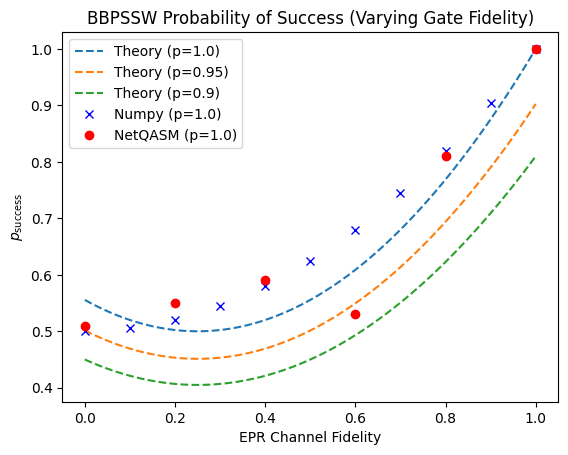

In [6]:
# Define gate fidelities to plot
gate_fids = [1.0, 0.95, 0.9]  # Example values

# Plot theoretical curves
ps = np.linspace(0, 1, 101)
for p in gate_fids:
    plt.plot(
        ps,
        [prob_succ_theory(f, p) for f in ps],
        linestyle='--',
        label=f'Theory (p={p})'
    )

# Plot simulation data (Numpy and NetQASM)
plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['P_Succ'],
    'xb', label='Numpy (p=1.0)'
)
plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM (p=1.0)'
)

plt.title('BBPSSW Probability of Success (Varying Gate Fidelity)')
plt.xlabel('EPR Channel Fidelity')
plt.ylabel(r'$p_\text{success}$')
plt.legend()
plt.show()

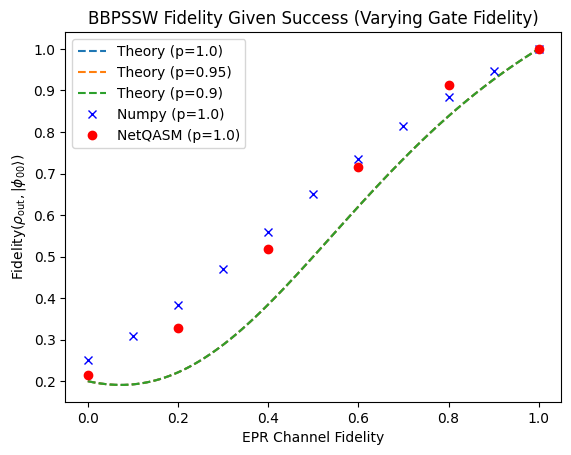

In [7]:
# Plot theoretical curves
for p in gate_fids:
    plt.plot(
        ps,
        [fidelity_succ_theory(f, p) for f in ps],
        linestyle='--',
        label=f'Theory (p={p})'
    )

# Plot simulation data
plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'xb', label='Numpy (p=1.0)'
)
plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM (p=1.0)'
)

plt.title(r'BBPSSW Fidelity Given Success (Varying Gate Fidelity)')
plt.xlabel('EPR Channel Fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
plt.legend()
plt.show()

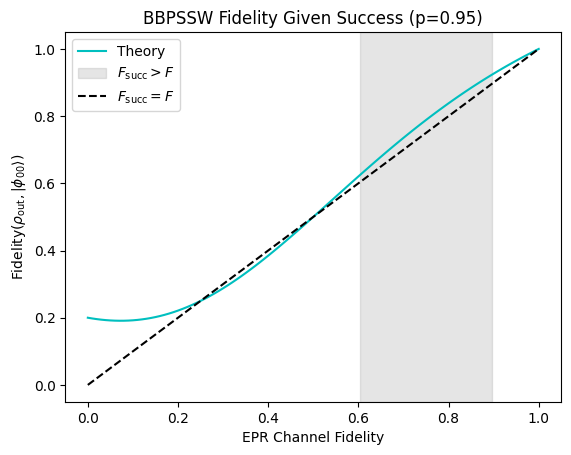

In [8]:
# Example for p = 0.95
p = 0.95
F_min, F_max = f_threshold(p)

# Plot F_succ and validity range
ps = np.linspace(0, 1, 101)
plt.plot(ps, [fidelity_succ_theory(f, p) for f in ps], 'c-', label='Theory')
plt.axvspan(F_min, F_max, alpha=0.2, color='gray', label=r'$F_{\text{succ}} > F$')
plt.plot(ps, ps, 'k--', label=r'$F_{\text{succ}} = F$')

plt.title(f'BBPSSW Fidelity Given Success (p={p})')
plt.xlabel('EPR Channel Fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
plt.legend()
plt.show()

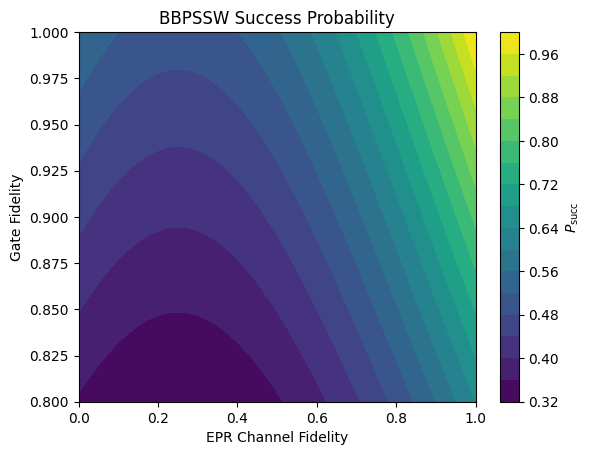

In [9]:
# Generate grid
F_vals = np.linspace(0, 1, 100)
p_vals = np.linspace(0.8, 1, 100)
F_grid, p_grid = np.meshgrid(F_vals, p_vals)

# Compute P_succ for all combinations
P_succ_grid = np.vectorize(prob_succ_theory)(F_grid, p_grid)

# Plot heatmap
plt.contourf(F_grid, p_grid, P_succ_grid, levels=20, cmap='viridis')
plt.colorbar(label=r'$P_{\text{succ}}$')
plt.xlabel('EPR Channel Fidelity')
plt.ylabel('Gate Fidelity')
plt.title('BBPSSW Success Probability')
plt.show()